# ِِDownload dataset

In [ ]:
# install requirements
! pip3 install tensorflow sklearn opencv-contrib-python flask flask-ngrok numpy scipy bayesian-optimization
# download dataset
! git clone https://github.com/UCSD-AI4H/COVID-CT
! cp COVID-CT/Images-processed/{CT_COVID.zip,CT_NonCOVID.zip} .
! rm -rf COVID-CT
! unzip CT_COVID.zip
! unzip CT_NonCOVID.zip

# Preprocessing

In [2]:
# Import dependencies.
import os
import numpy as np
import cv2
from scipy.io import savemat

# Create labels.
C = np.ones((349,))
N = np.zeros((397,))
labels = np.concatenate((C, N), axis=0)

# Load the datased and resize to imagenet size.
covid = os.listdir('CT_COVID')
n_covid = os.listdir('CT_NonCOVID')
data=[]


for img_path in covid:
  img = cv2.imread('CT_COVID/'+img_path, cv2.IMREAD_GRAYSCALE)
  data.append(cv2.resize(img, (224, 224)))
  

for img_path in n_covid:
  img = cv2.imread('CT_NonCOVID/'+img_path, cv2.IMREAD_GRAYSCALE)
  data.append(cv2.resize(img, (224, 224)))
  
# Normalization.
data = np.array(data)/255.
print(data.shape)
print(labels.shape)


(746, 224, 224)
(746,)


# Visualization

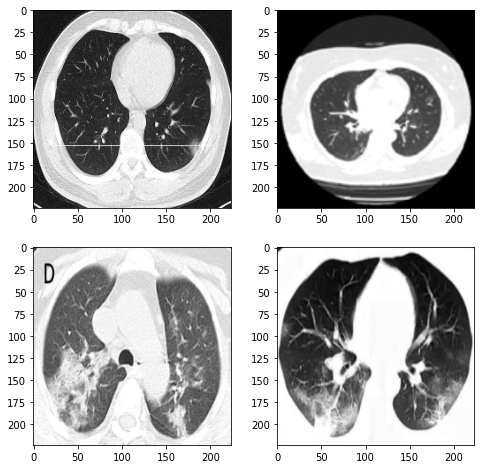

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0, 0].imshow(np.squeeze(data[40]), cmap='gray')
axs[0, 1].imshow(np.squeeze(data[50]), cmap='gray')
axs[1, 0].imshow(np.squeeze(data[30]), cmap='gray')
axs[1, 1].imshow(np.squeeze(data[150]), cmap='gray')


In [4]:
from sklearn.decomposition import PCA

data = data.reshape(data.shape[0], -1)
Y = labels

pca = PCA(n_components=2)
X = pca.fit_transform(data)

# **Model(SVM) and optimization**

In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
from bayes_opt import BayesianOptimization
from warnings import simplefilter
from sklearn.svm import SVC, NuSVC
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from warnings import simplefilter



def svm_evaluate(X, Y):
    simplefilter(action='ignore')
    svm = NuSVC(nu=0.4, kernel='rbf', gamma=0.0093, shrinking=True, tol=0.00001,
              max_iter=185, random_state=1, class_weight='balanced', probability=True)
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=603,)
    scores = cross_val_score(svm, X, Y, cv=cv)
    print(np.mean(scores))

    return np.mean(scores)
   


params = svm_evaluate(X, Y)


0.6218198198198198


# Results

In [6]:
# Import Dependencies.
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from warnings import simplefilter
from scipy.io import loadmat

# Calculate time.
s_time = time.time()
# Load the extracted features.

# Create the Classifier.
clf = NuSVC(nu=0.4, gamma = 0.0093, kernel='rbf' , shrinking=True, tol=0.00001,
          max_iter=185, random_state=1, class_weight='balanced', probability=True)
simplefilter(action='ignore')

# Perform Cross Validation to Measure the Performance.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=603,)

# TODO: Probably not the most optimal way to do this.
accuracy = cross_val_score(clf, X, Y, cv=cv)
scores = cross_val_score(clf, X, Y, cv=cv, scoring='roc_auc')
recall = cross_val_score(clf, X, Y, cv=cv, scoring='recall')
precision = cross_val_score(clf, X, Y, cv=cv, scoring='precision')
f1 = (2 * recall * precision) / (precision + recall)

print(f'time: {time.time() -  s_time}')
print(f'Accuracy: {np.mean(accuracy)} + {np.std(accuracy)}')
print(f'Area Under Curve: {np.mean(scores)} + {np.std(scores)}')
print(f'Recall: {np.mean(recall)} + {np.std(recall)}')
print(f'Presicion: {np.mean(precision)} + {np.std(precision)}')
print(f'f1 score: {np.mean(f1)} + {np.std(f1)}')


time: 4.586503028869629
Accuracy: 0.6218198198198198 + 0.06033881288115863
Area Under Curve: 0.6720493966817497 + 0.0570086266676935
Recall: 0.6045378151260504 + 0.09385933941246265
Presicion: 0.5933871650018246 + 0.06163962575133957
f1 score: 0.5972243110061459 + 0.07281341293489457


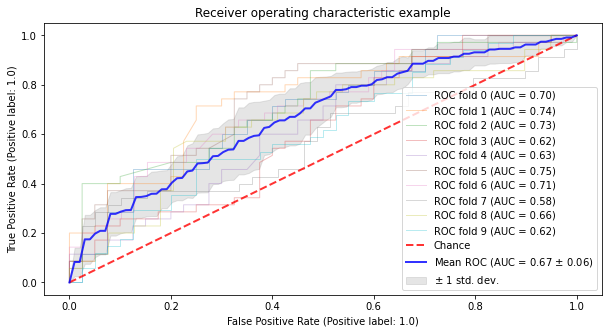

In [7]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize = (10, 5))
for i, (train, test) in enumerate(cv.split(X, Y)):
    clf.fit(X[train], Y[train])
    viz = plot_roc_curve(clf, X[test], Y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

# **Model(KNN)**

In [8]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
from bayes_opt import BayesianOptimization
from warnings import simplefilter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from warnings import simplefilter
from scipy.io import loadmat


def knn_evaluate(X, Y):
    simplefilter(action='ignore')
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=603,)
    neigh = KNeighborsClassifier(n_neighbors=3)
    scores = cross_val_score(neigh, X, Y, cv=cv)

    return np.mean(scores)
   

scores = knn_evaluate(X, Y)
print(scores)


0.6366306306306307


# Results

In [9]:
# Import Dependencies.
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from warnings import simplefilter
from scipy.io import loadmat

# Calculate time.
s_time = time.time()

# Create the Classifier.
clf = KNeighborsClassifier(n_neighbors=3)

# Perform Cross Validation to Measure the Performance.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=603,)

# TODO: Probably not the most optimal way to do this.
accuracy = cross_val_score(clf, X, Y, cv=cv)
scores = cross_val_score(clf, X, Y, cv=cv, scoring='roc_auc')
recall = cross_val_score(clf, X, Y, cv=cv, scoring='recall')
precision = cross_val_score(clf, X, Y, cv=cv, scoring='precision')
f1 = (2 * recall * precision) / (precision + recall)

print(f'time: {time.time() -  s_time}')
print(f'Accuracy: {np.mean(accuracy)} + {np.std(accuracy)}')
print(f'Area Under Curve: {np.mean(scores)} + {np.std(scores)}')
print(f'Recall: {np.mean(recall)} + {np.std(recall)}')
print(f'Presicion: {np.mean(precision)} + {np.std(precision)}')
print(f'f1 score: {np.mean(f1)} + {np.std(f1)}')


time: 0.17739272117614746
Accuracy: 0.6366306306306307 + 0.054593943444515756
Area Under Curve: 0.6857872764490411 + 0.0671017377187609
Recall: 0.584453781512605 + 0.09263329038872772
Presicion: 0.6209338719702144 + 0.06371990412106175
f1 score: 0.5982002748014595 + 0.07038434866482465


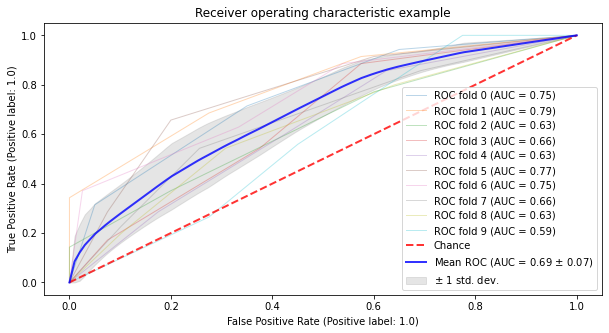

In [10]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize = (10, 5))
for i, (train, test) in enumerate(cv.split(X, Y)):
    clf.fit(X[train], Y[train])
    viz = plot_roc_curve(clf, X[test], Y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()